In [2]:
#Imports
import pandas as pd
import numpy as np 
import nilearn 
import nibabel as nib
import os
import matplotlib.pyplot as plt
import glob

from nilearn import plotting, image
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.maskers import NiftiMasker
from nilearn.plotting import plot_design_matrix
from nilearn import image
from nilearn import masking
from numpy import savetxt
from nilearn.maskers import NiftiSpheresMasker
from nilearn.reporting import get_clusters_table


#Submit job to HPC
#subprocess.call(['qsub', '-l', 'procs=1,mem=24gb,walltime=12:00:00 -I'])

# Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
            
# Data path
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'

# Paths for the directories
output_dir = '/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/'
matrix_dir = os.path.join(output_dir, 'matrix/')
image_dir = os.path.join(output_dir, 'image/')
residuals_dir = os.path.join(output_dir, 'residuals/')
z_score_dir = os.path.join(output_dir, 'z_score/')
beta_dir = os.path.join(output_dir, 'beta_estimates/')
clusters_dir = os.path.join(output_dir, 'clusters/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(matrix_dir):
    os.makedirs(matrix_dir)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(residuals_dir):
    os.makedirs(residuals_dir)
if not os.path.exists(z_score_dir):
    os.makedirs(z_score_dir)
if not os.path.exists(beta_dir):
    os.makedirs(beta_dir)
if not os.path.exists(clusters_dir):
    os.makedirs(clusters_dir)


201603
16


/tmp/ipykernel_24064/2749740035.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  events_list = events.append(events)
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:74: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn("'trial_type' column not found "


MemoryError: 

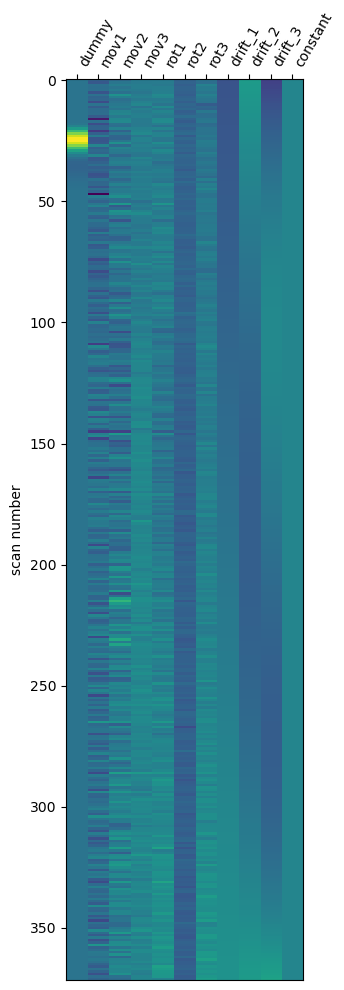

In [3]:
# ---------- FIRST LEVEL ANALYSIS ------------

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

for index in range(102, 103):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print(subj_num)

    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0{}.session1_split_name_sub-0{}_ses-1_T2w/_run_1/*.nii.gz".format(subj_num, subj_num, subj_num))[0]

    tr=(df.iloc[index]['func.TR'])
    hrf_model = 'spm'
    
    func_img = nib.load(subject_path)                                
    header = func_img.header

    n_scans = func_img.shape[3]    
    frame_times = np.arange(n_scans) * tr                             # corresponding frame times

    # --- Events regressor --- 
    
    onset = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]
    duration = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    events = pd.DataFrame({'onset': onset,'duration': duration})
    events_list = events.append(events)

    print(df.iloc[index]['func.sensory.onset'])
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/_scan_info_subject_id0{}.session1_split_name_sub-0{}_ses-1_T2w/_run_1/*.csv".format(subj_num, subj_num, subj_num, subj_num))[0]

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Compute design matrix --- 
   
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=hrf_model, 
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 
    savetxt(matrix_dir+'matrix_sub-0{}_ses-1.csv'.format(subj_num), design_matrix, delimiter=',')


    # --- Fitting a first-level model --- 
    
    fmri_glm = FirstLevelModel(t_r=7,
                               drift_model='polynomial',
                               #mask_img=mask,                       # mask defined earlier(SIGMA_InVivo_Brain_Mask.) but not compatible for .fit
                               signal_scaling=False,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    nib.save(residuals, residuals_dir+'residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))         #save this to nifti

    
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    nib.save(statistical_map['z_score'], z_score_dir+'z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))          #save z map
    nib.save(statistical_map['effect_size'], beta_dir+'beta_sub-0{}_ses-1.nii.gz'.format(subj_num))            #save the betaestimates


    #-- Plot and save as nifti file ---
    
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 1.9, 
                                       title = 'Rat {}'.format(subj_num))
    
    plt.savefig(image_dir+'stat_map_sub-0{}_ses-1.png'.format(subj_num))
    


In [ ]:
    # --- Extract the clusters --- 
    
    #from nilearn.reporting import get_clusters_table
    #from nilearn.maskers import NiftiSpheresMasker
    
    #table = get_clusters_table(stat_img = z_score_dir+'z_score_sub-0{}_ses-1.nii.gz'.format(subj_num), 
    #                           stat_threshold=3.1, cluster_threshold=20)
    #table.set_index("Cluster ID", drop=True)
    #table.head()

    #coords = table.loc[range(0, len(table)), ['X', 'Y', 'Z']].values                     # get the clusters' x, y, and z coordinates (if want the 4 largest, range(0, 4)
    #masker = NiftiSpheresMasker(coords)                                                  #extracts time series data from a set of spherical regions of interest (ROIs) in a 3D fMRI image
    #real_timeseries = masker.fit_transform(subject_path)                                 #applies the masker to an fMRI image, outputs 2D numpy array
    
    #savetxt(clusters_dir+'cluster_sub-0{}_ses-1.csv'.format(subj_num), real_timeseries, delimiter=',')       #save as .csv file
